In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

import pennylane as qml
import matplotlib.pyplot as plt
import pickle, os

# ------------------ PARAMETERS ------------------
TRAIN_CSV = "heart_train.csv"
TEST_CSV = "heart_test.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.3
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16
EPOCHS = 30           # reduced for speed
LEARNING_RATE = 5e-4
N_LAYERS = 2          # quantum circuit layers
MAX_QUBITS = 8        # limit for simulation


In [2]:
# ------------------ 1) Data Loading ------------------
train_df = pd.read_csv(TRAIN_CSV)

cols_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
le_dict = {}
for col in cols_to_encode:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    le_dict[col] = le

X = train_df.drop('HeartDisease', axis=1)
y = train_df['HeartDisease']

# Split train/val/test
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=TEST_SIZE,
                                                          random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5,
                                                random_state=RANDOM_STATE, stratify=y_valtest)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [3]:
# ------------------ 2) Qubit setup ------------------
n_features = X_train.shape[1]
n_qubits = min(n_features, MAX_QUBITS)

if n_features > n_qubits:
    pca = PCA(n_components=n_qubits, random_state=RANDOM_STATE)
    X_train_q = pca.fit_transform(X_train)
    X_val_q = pca.transform(X_val)
    X_test_q = pca.transform(X_test)
else:
    X_train_q = X_train
    X_val_q = X_val
    X_test_q = X_test

print(f"Using {n_qubits} qubits, input dim to quantum layer: {X_train_q.shape[1]}")


Using 8 qubits, input dim to quantum layer: 8


In [4]:
# ------------------ 3) Quantum circuit ------------------
dev = qml.device("default.qubit", wires=n_qubits)

def variational_circuit(params, x=None):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    for l in range(params.shape[0]):
        for q in range(n_qubits):
            qml.RX(params[l, q, 0], wires=q)
            qml.RY(params[l, q, 1], wires=q)
            qml.RZ(params[l, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1) % n_qubits])

@qml.qnode(dev, interface='tf')
def qnode_tf(inputs, weights):
    variational_circuit(weights, x=inputs)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]



In [5]:
class QNNLayer(tf.keras.layers.Layer):
    def __init__(self, n_qubits, n_layers, **kwargs):
        super().__init__(**kwargs)
        init_weights = np.random.uniform(low=0, high=2*np.pi, size=(n_layers, n_qubits, 3))
        self.weights_var = tf.Variable(init_weights, dtype=tf.float32, trainable=True)
        self.n_qubits = n_qubits
        self.n_layers = n_layers

    def call(self, inputs):
        return tf.map_fn(
            lambda x: tf.cast(qnode_tf(x, self.weights_var), tf.float32),
            inputs,
            fn_output_signature=tf.TensorSpec(shape=(self.n_qubits,), dtype=tf.float32)
        )

In [6]:

# ------------------ 5) Build hybrid model ------------------
inp = Input(shape=(X_train_q.shape[1],))
x = Dense(32, activation='relu')(inp)
x = Dense(n_qubits, activation='linear')(x)
x = QNNLayer(n_qubits=n_qubits, n_layers=N_LAYERS)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1, activation='sigmoid')(x)

hybrid_model = Model(inputs=inp, outputs=out)
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='binary_crossentropy', metrics=['accuracy'])

hybrid_model.summary()




Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x0000027A78003D80>. Note that functions defined in certain environments, like the interactive Python shell, 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ qnn_layer (QNNLayer)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 713 (2.79 KB)

 Trainable params: 713 (2.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# ------------------ 6) Train ------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = hybrid_model.fit(X_train_q, y_train, validation_data=(X_val_q, y_val),
                           epochs=EPOCHS, batch_size=BATCH_SIZE,
                           callbacks=[early_stop], verbose=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step
Accuracy: 0.8288288288288288
F1: 0.848
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        50
           1       0.83      0.87      0.85        61

    accuracy                           0.83       111
   macro avg       0.83      0.82      0.83       111
weighted avg       0.83      0.83      0.83       111

Confusion Matrix:
 [[39 11]
 [ 8 53]]


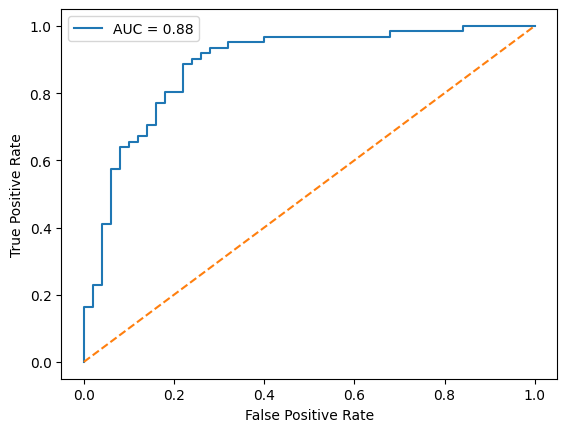

In [8]:

# ------------------ 7) Evaluate ------------------
y_pred_prob = hybrid_model.predict(X_test_q).ravel()
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("F1:", f1_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", cm)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [9]:

# ------------------ 8) Predict on final test set ------------------
test_df = pd.read_csv(TEST_CSV)
ids = test_df["id"] if "id" in test_df.columns else pd.Series(range(len(test_df)))

for col in cols_to_encode:
    test_df[col] = le_dict[col].transform(test_df[col].astype(str))

X_final_test = test_df.drop(columns=["id"], errors="ignore")
X_final_test = scaler.transform(X_final_test)

if n_features > n_qubits:
    X_final_test_q = pca.transform(X_final_test)
else:
    X_final_test_q = X_final_test

test_pred_prob = hybrid_model.predict(X_final_test_q).ravel()
test_pred_class = (test_pred_prob > 0.5).astype(int)

submission = pd.DataFrame({"id": ids, "HeartDisease": test_pred_class})
submission.to_csv("submission_qnn.csv", index=False)
print("✅ submission_qnn.csv saved")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ submission_qnn.csv saved


In [10]:
# ------------------ 9) Save scaler + weights ------------------os.makedirs('model_qnn', exist_ok=True)
with open('model_qnn/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

hybrid_model.save_weights('model_qnn/model.weights.h5')
print("✅ Model and scaler saved in model_qnn/")


✅ Model and scaler saved in model_qnn/
